In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [56]:
# https://web.archive.org/web/20090722233436/http://blog.brandonpelfrey.com/?p=303

class Neighbor:
    def __init__(self, i, j, q, q2): # q and q2 are weighted distances 
        # int
        self.i = i 
        self.j = j
        # float
        self.q = q
        self.q2 = q2

    

class Particle:
    def __init__(self, pos, mass, rho, sigma, beta): # sigma and beta controls the viscosity of the flow
        # vec2
        self.pos = pos
        self.pos_old = pos + 0.001 * np.random.rand()
        self.vel = np.zeros(2)
        self.force = np.array([0,-G])
        self.visual_pos = pos
        # float
        self.mass = mass
        self.rho = rho
        self.rho_near = 0
        self.press = 0
        self.press_near = 0
        self.sigma = sigma
        self.beta = beta
        # list
        self.neighbors = []

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def reset(self):
        self.rho = 0
        self.rho_near = 0
        self.neighbors = []



In [131]:
WIDTH = HEIGHT = 1
N = 250 # Number of Particles in the simulation
dt = 0.1 # time-step


G = 0.02 * 0.25 # Gravitational Constant for our simulation

spacing = 0.08 # Spacing of particles
k = spacing / 1000 # Far pressure weight
k_near = k*10 # Near pressure weight
rest_density = 3 # Rest Density
r=spacing*1.25 # Radius of Support
rsq=r*r # squared for performance

SIM_W = WIDTH # width of the sim
SIM_H = HEIGHT # height of the sim
bottom = 0 # The floor of the world

wall_spring = 0.1
vel_damp = 0.5

mass = 1
rho = 0
sigma = 0.1
beta = 0

def init_particles():
    particle_list = []
    for x in range(1, WIDTH, spacing):
        for y in range(1, HEIGHT, spacing):
            pos = np.array([x,y])
            particle = Particle(pos, mass, rho, sigma, beta)
            if len(particle_list)<N:
                particle_list.append(particle)
            else: break
    return particle_list

xmin = ymin = 0
xmax = WIDTH/2
ymax = HEIGHT/2

def init_particles():
    particle_list = []
    x_pos, y_pos = xmin, ymin
    for _ in range(N):
        pos = np.array([x_pos,y_pos])
        particle = Particle(pos, mass, rho, sigma, beta)
        particle_list.append(particle)
        x_pos += spacing
        if x_pos > xmax:
            x_pos = xmin
            y_pos += spacing

    return particle_list

def init_particles():
    particle_list = []
    divider = 4
    for x in np.arange(xmin, xmax, spacing/divider):
        for y in np.arange(ymin, ymax, spacing/divider):
            pos = np.array([x,y])
            particle = Particle(pos, mass, rho, sigma, beta)
            particle_list.append(particle)
    return particle_list



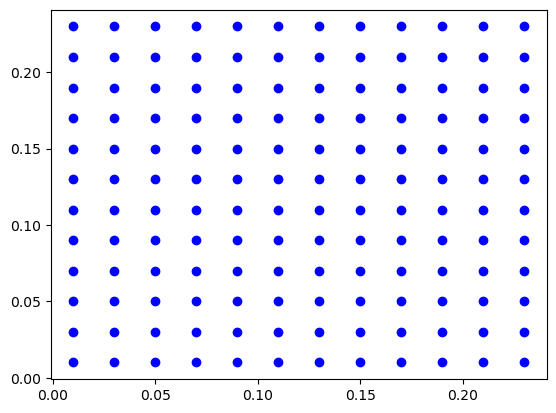

In [95]:
particle_list = init_particles()
pos_list = visualize(particle_list)

In [58]:
# Density: to know the density of “stuff” around a particle
def density_update(particle_list):
    for i, particle_i in enumerate(particle_list):
        d = 0
        dn = 0
        for j, particle_j in enumerate(particle_list):
            # By doing this test, we insure there is only one computation per pair of particles
            # And that there is no computation between a particle and itself
            if (i >= j): continue 
    
            rij = particle_j.pos - particle_i.pos
            dist2 = np.linalg.norm(rij)**2 # square distance
            if dist2 < rsq:
                length = np.sqrt(dist2)
    
                q = 1 - length / r
                q2 = q**2
                q3 = q**3
                
                d += q2
                dn += q3
                particle_j.rho += q2
                particle_j.rho_near += q3
    
                neighbor = Neighbor(i, j, q, q2)
                particle_i.add_neighbor(neighbor)
    
        particle_i.rho += d
        particle_i.rho_near += dn

    return particle_list
    

In [128]:
# Visualize frame
def visualize(particle_list):
    pos_list = []
    for particle in particle_list:
        pos_list.append(particle.pos)
    x_values = [pos[0] for pos in pos_list]
    y_values = [pos[1] for pos in pos_list]
    plt.plot(x_values, y_values, 'bo')  
    plt.xlim(0, SIM_W)  
    plt.ylim(0, SIM_H)  

    return pos_list



In [60]:
# Pressure Calculation
def pressure_update(particle_list):
    for i, particle_i in enumerate(particle_list):
        particle_i.press = k * (particle_i.rho - rest_density)
        particle_i.press_near = k_near * particle_i.rho_near

    return particle_list


# Pressure Force Calculation:
# We will force particles in or out from their neighbors based on their difference from the rest density.
def pressure_force_update(particle_list):
    for i, particle_i in enumerate(particle_list):
        dx = np.zeros(2)
        # ncount = len(particle_i.neighbors)
        for neighbor in particle_i.neighbors:
            j = neighbor.j
            q = neighbor.q
            q2 = neighbor.q2
            particle_j = particle_list[j]
            rij = rij = particle_j.pos - particle_i.pos
            dm = (particle_i.press + particle_j.press) * q + \
                (particle_i.press_near + particle_j.press_near) * q2 # magnitude of the force
            direction = rij / np.linalg.norm(rij) # unit direction of the force
            D = direction * dm 
            dx += D 
            particle_j.force += D
    
        particle_i.force -= dx

    return particle_list

            
    


In [117]:
# Viscous Force Calculation (later)
def viscosity_force_update(particle_list):
    for i, particle_i in enumerate(particle_list):
        for neighbor in particle_i.neighbors:
            j = neighbor.j
            particle_j = particle_list[j]
            rij = particle_j.pos - particle_i.pos
            length = np.linalg.norm(rij)
            q = length/r
            rijn = rij/length
            u = np.dot((particle_i.vel -particle_j.vel), rijn) # Get the projection of the velocities onto the vector between them.
    
            if u>0:
                I = (1-q)*(particle_j.sigma * u + particle_j.beta * u**2) * rijn
                particle_i.vel -= I * vel_damp
                particle_j.vel += I * vel_damp
    return particle_list

In [118]:
# update per frame

def update(particle_list = None):
    for particle in particle_list:
        particle.pos_old = particle.pos
        particle.pos = particle.vel*dt + particle.pos
        particle.pos = particle.force/mass*dt + particle.pos
        particle.force = np.array([0,-G])
        particle.vel = (particle.pos - particle.pos_old)/dt # for later
        particle.visual_pos = particle.pos.copy()
    
    	# If the velocity is really high, we're going to cheat and cap it.
    	# This will not damp all motion. It's not physically-based at all. Just
        max_vel = 2
        vel_mag = np.linalg.norm(particle.vel)**2
        if vel_mag > max_vel**2:
            particle.vel = particle.vel * vel_damp
            
        # If the particle is outside the bounds of the world, then
        # Make a little spring force to push it back in.
        if particle.pos[0] < 0: 
            particle.force = particle.force - np.array([particle.pos[0] - 0, 0]) * wall_spring
            particle.visual_pos[0] = 0
        if particle.pos[0] > SIM_W: 
            particle.force = particle.force - np.array([particle.pos[0] - SIM_W,0]) * wall_spring
            particle.visual_pos[0] = SIM_W

        if particle.pos[1] < bottom: 
            particle.force = particle.force - np.array([0, particle.pos[1] - SIM_W]) * wall_spring
            particle.visual_pos[1] = bottom

        if particle.pos[1] > SIM_H: 
            particle.force = particle.force - np.array([0, particle.pos[1] - SIM_H]) * wall_spring
            particle.visual_pos[1] = SIM_H

        particle.reset()

    particle_list = density_update(particle_list)
    particle_list = pressure_update(particle_list)
    particle_list = pressure_force_update(particle_list)
    particle_list = viscosity_force_update(particle_list)
        
    return particle_list
    

In [132]:
num_frames = 300

def run_simulation(num_frames):
    positions_list = []
    particle_list = init_particles()

    for _ in range(num_frames):
        particle_list = update(particle_list)
        positions = [particle.visual_pos for particle in particle_list]
        positions_list.append(positions)
        
    return np.array(positions_list)

positions_list = run_simulation(num_frames)
    

In [134]:
positions_list.shape

(300, 625, 2)

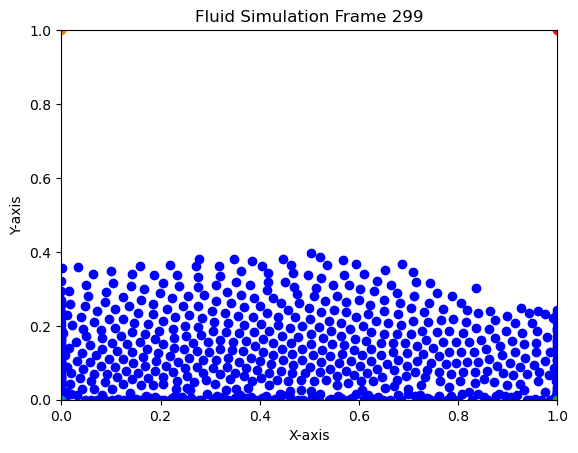

In [133]:
def animate(frame):
    plt.cla()  # Clear the current plot
    plt.scatter(particles[frame][:, 0], particles[frame][:, 1], c='blue', marker='o')
    plt.scatter(0,0);plt.scatter(0,HEIGHT); plt.scatter(WIDTH,0); plt.scatter(WIDTH,HEIGHT);
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Fluid Simulation Frame {}'.format(frame))
    plt.xlim(0, SIM_W)  
    plt.ylim(0, SIM_H)  

# Create the animation
particles = positions_list
fig = plt.figure()
interval = dt*1000
fps = 1/dt

interval = 1/60*1000
fps = 60
ani = FuncAnimation(fig, animate, frames=num_frames, interval=interval)

# Save the animation as a GIF
ani.save('fluid_simulation.gif', writer='pillow', fps=fps)

plt.show()


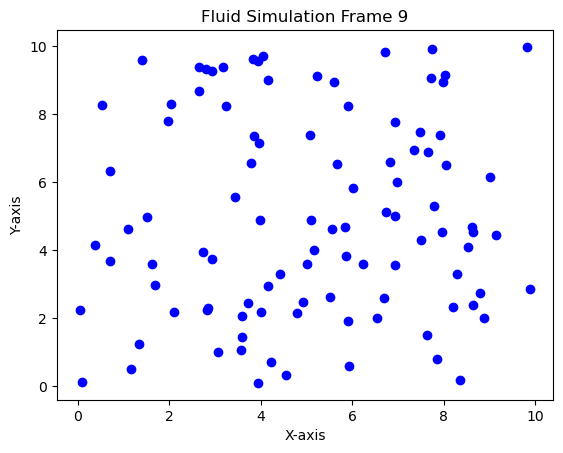

In [67]:

# Example function to update the plot for each frame
def update_frame(frame):
    plt.cla()  # Clear the current plot
    plt.scatter(particles[frame][:, 0], particles[frame][:, 1], c='blue', marker='o')  # Plot particles for the current frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Fluid Simulation Frame {}'.format(frame))

# Example data: particles positions for each frame
# Replace this with actual data from your simulation
num_frames = 10
num_particles = 100
particles = [np.random.rand(num_particles, 2) * 10 for _ in range(num_frames)]

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update_frame, frames=num_frames, interval=100)

# Save the animation as a GIF
ani.save('fluid_simulation.gif', writer='pillow', fps=10)

plt.show()


In [68]:
# Update velocities and position
def position_update(particle_list):
    for particle in particle_list:
        F = particle.force
        m = particle.mass
        vel_old = particle.vel
        vel_new = F/m*dt + vel_old
        particle.vel = vel_new
        # particle.vel_old = vel_old
        old_pos = particle.pos_old
        new_pos = old_pos + vel_new * dt
        
    
